<div class="alert alert-block alert-success">

# Plaut Model > plaut_model

### Purpose
Implement the Plaut Model

### Date Created
November 11, 2019
***
#### Revisions
 - Jan 01, 2020: Happy New Year! Minor bug fixes to folder creation in training
 - Dec 30, 2019: Update filepaths in code to match new file organization
 - Nov 28, 2019: Update training epochs to 500+100, add training for anchors
 - Nov 27, 2019: Move dataset class, helper functions to separate files, Add plotting for accuracy for plaut dataset, anchors and probes
 - Nov 25, 2019: Update get_accuracy function to correspond to sigmoid activated output, Lower print/plot frequency
 - Nov 24, 2019: Replace BCEWithLogitsLoss with BCELoss, and added sigmoid activation to model output
 - Nov 21, 2019: Include correct frequency, fixes to dataset structure
 - Nov 14, 2019: Updates to include frequency
 - Nov 11, 2019: Create file, implement initial Plaut model and train

</div>

### Import Required Libraries

In [9]:
import pandas as pd
import numpy as np
import os
import datetime
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from plaut_dataset import plaut_dataset
from helpers import *
from IPython.display import Audio, display

### Import Data

In [2]:
# import dataset from csv files
# multiple csv files can be concatenated in format: ["filename1", True/False, "filename2", True/False, ...]
# True/False indicates whether to override frequencies to log(2)

plaut_ds = plaut_dataset(["../dataset/plaut_dataset.csv", False])
anc_ds = plaut_dataset(["../dataset/anchors.csv", False])
probe_ds = plaut_dataset(["../dataset/probes.csv", False])
plaut_anc_ds = plaut_dataset(['../dataset/plaut_dataset.csv', True, '../dataset/anchors.csv', False])

# initialize dataloader to feed data into model
plaut_loader = DataLoader(plaut_ds, batch_size=len(plaut_ds), num_workers=0)
anc_loader = DataLoader(anc_ds, batch_size=len(anc_ds), num_workers=0)
probe_loader = DataLoader(probe_ds, batch_size=len(probe_ds), num_workers=0)
plaut_anc_loader = DataLoader(plaut_anc_ds, batch_size=len(plaut_anc_ds), num_workers=0)

### Network Architecture

In [3]:
class plaut_net(nn.Module):
    def __init__(self):
        super(plaut_net, self).__init__()
        self.layer1 = nn.Linear(105, 100)
        self.layer2 = nn.Linear(100, 61)
    
    def forward(self, x):
        x = torch.sigmoid(self.layer1(x))
        return torch.sigmoid(self.layer2(x))

### Training Function

In [4]:
def train(model, plaut_loader, plaut_anc_loader, anc_loader, probe_loader, folder, lr=0.001):
    # define loss function and optimizer
    criterion = nn.BCELoss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Initialize arrays to store epochs, train loss
    epochs, losses = [], []
    
    # Select word types to calculate accuracy for
    types = ["HEC", "HRI", "HFE", "LEC", "LFRI", "LFEEXPT"] # calculate accuracy of these types
    anc_types = ["ANC_REG", "ANC_EXC", "ANC_AMB"]
    probe_types = ["PRO_REG", "PRO_EXC", "PRO_AMB"]
    
    # Initialize arrays to store accuracy of plaut dataset, anchors, probes
    acc = [[], [], [], []]
    anc_acc = [[] for i in anc_types]
    probe_acc = [[] for i in probe_types]
    
    for epoch in range(600):
        if epoch < 500: # use only plaut dataset for first 500 epochs
            data_loader = plaut_loader
        else: # after, train with both plaut + anchors
            data_loader = plaut_anc_loader
        
        avg_loss = 0 # initialize avg loss
        for i, data in enumerate(data_loader): 
            # extract frequency, inputs, labels
            freq = data["frequency"].float().view(-1, 1) # reshape to [batch_size x 1] to match output size
            inputs = data["graphemes"].float()
            labels = data["phonemes"].float()
            
            #forward pass + backward pass + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss = (loss*freq).mean() # scale loss by frequency, then find mean
            avg_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # calculate loss and save loss to array
        losses.append(avg_loss)
        epochs.append(epoch+1)
        
        # calculate accuracy over the different types for plaut dataset
        temp_acc = get_accuracy(model, plaut_loader, types)
        acc[0].append((temp_acc[0]+temp_acc[1])/2) # average of HFR consistent and inconsistent
        acc[1].append(temp_acc[2]) # HFE
        acc[2].append((temp_acc[3]+temp_acc[4])/2) # average of LFR consistent and inconsistent
        acc[3].append(temp_acc[5]) # LFE
        
        # calculate accuracy over the different types for anchors
        temp_acc = get_accuracy(model, anc_loader, anc_types, vowels_only=True)
        for i in range(len(anc_types)):
            anc_acc[i].append(temp_acc[i])
            
        # calculate accuracy over the different types for probes
        temp_acc = get_accuracy(model, probe_loader, probe_types, vowels_only=True)
        for i in range(len(probe_types)):
            probe_acc[i].append(temp_acc[i])
        
        # print stats every 5 epochs
        if epoch % 1 == 0:
            print("[EPOCH %d] loss: %.6f" % (epoch+1, avg_loss))
        
        # plot loss every 5 epochs
        if epoch % 50 == 49:
            make_plot(epochs, [losses], ["Train Loss"], "Epoch", "Loss", "Training Loss")
            make_plot(epochs, acc, ["HFR", "HFE", "LFR", "LFE"], "Epoch", "Accuracy", "Training Accuracy")
            make_plot(epochs, anc_acc, anc_types, "Epoch", "Accuracy", "Anchor Accuracy")
            make_plot(epochs, probe_acc, probe_types, "Epoch", "Accuracy", "Probe Accuracy")
            

    # plot final loss curve and save
    plt.figure()
    plt.title("Training Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(losses, label="Training Loss")
    plt.savefig("../test/"+folder+"/lossplot_final.png", dpi=150)
    plt.close()

### Training

In [18]:
# create a new folder for every run
path = Path(os.getcwd()).parent #get parent (Plaut_Model) directory filepath
now = datetime.datetime.now()
date = now.strftime("%b").lower()+now.strftime("%d")
i = 1

while True:
    try:
        rootdir = str(path)+"/test/"+date+"_test"+'{:02d}'.format(i)
        print(rootdir)
        os.mkdir(rootdir)
        break
    except:
        i += 1


print("Test Results saved in :", rootdir)

#torch.manual_seed(1) # initialize random seed
#model = plaut_net() # initialize model
#train(model, plaut_loader, plaut_anc_loader, anc_loader, probe_loader, rootdir, lr=0.1) # train!!!!

/Users/BrianLam/UTSC Research/Plaut_Model/test/jan01_test01
Test Results saved in : /Users/BrianLam/UTSC Research/Plaut_Model/test/jan01_test01


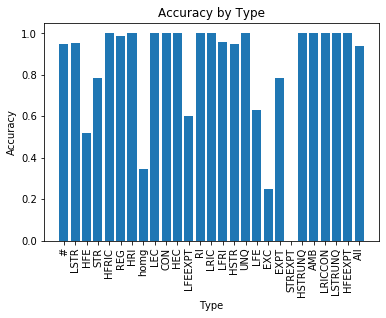

In [7]:
# obtain list of categories in dataset, and add "All" for overall accuracy
types = list(plaut_ds.df["type"].unique())
types.append("All")
    
accuracy = get_accuracy(model, plaut_loader, types)


# plot in bar graph
plt.bar(types, accuracy)
plt.xticks(rotation='vertical')
plt.xlabel("Type")
plt.ylabel("Accuracy")
plt.title("Accuracy by Type")
plt.savefig("../test/"+rootdir+"/accuracy_chart_final.png", dpi=150)
plt.show()


In [8]:
# function to get the accuracy of a particular category
def get_accuracy2 (model, train_loader, cat='All'):
    correct = 0
    total = 0
    for i, data in enumerate (train_loader): # get batch from dataloader
        # extract inputs, labels, type from batch
        inputs = data["graphemes"].float()
        labels = data["phonemes"].float()
        types = pd.DataFrame(data["type"])
        
        outputs = model(inputs) # find prediction using model
        outputs = outputs.round() # round output to 0 or 1
        compare = torch.eq(outputs, labels).sum(dim=1) # compare with labels
        
        if cat == 'All':
            correct += torch.eq(compare, 61).sum().item() # count as correct if all 61 elements match label
            total += len(compare)
        else:
            types = types.apply(lambda x: x == cat) # check for desired type
            compare = pd.DataFrame(compare)
            correct += ((types == True) & (compare == 61)).sum()[0] # count as correct if desired type AND all 61 elements match total
            total += (types==True).sum()[0] # count all of the desired type
    
    return correct/(total) # return accuracy

In [9]:
def get_accuracy_vowels (model, train_loader, cat=['REG', 'EXC', 'AMB']):
    correct = [0, 0, 0]
    total = [0, 0, 0]
    for i, data in enumerate (train_loader):
        inputs = data["graphemes"].float()
        labels = data["phonemes"].float()
        labels = labels[:, len(phoneme_onset):len(phoneme_onset)+len(phoneme_vowel)]
        
        outputs = model(inputs)
        outputs = outputs[:, len(phoneme_onset):len(phoneme_onset)+len(phoneme_vowel)]
        outputs = torch.sigmoid(outputs).round()
        compare = torch.eq(outputs, labels).sum(dim=1)
        for i in range(len(cat)):
            types = pd.DataFrame(data["type"])
            #print(types)
            types = types.apply(lambda x: x == cat[i])
            #print(types)
            #break
            compare = pd.DataFrame(compare)
            correct[i] += ((types == True) & (compare == len(phoneme_vowel))).sum()[0]
            total[i] += (types==True).sum()[0]
    return correct, total

In [10]:
a = torch.tensor([[1, 2, 3], [4, 5, 6]])

In [11]:
a[:, 1:3]

tensor([[2, 3],
        [5, 6]])

In [12]:
phoneme_onset = ['s', 'S', 'C', 'z', 'Z', 'j', 'f', 'v', 'T', 'D',
                 'p', 'b', 't', 'd', 'k', 'g', 'm', 'n', 'h', 'l', 'r', 'w', 'y']
phoneme_vowel = ['a', 'e', 'i', 'o', 'u', '@',
                 '^', 'A', 'E', 'I', 'O', 'U', 'W', 'Y']
phoneme_codas = ['r', 'l', 'm', 'n', 'N', 'b', 'g', 'd', 'ps', 'ks',
                 'ts', 's', 'z', 'f', 'v', 'p', 'k', 't', 'S', 'Z', 'T', 'D', 'C', 'j']

In [13]:
len(phoneme_onset)

23

In [14]:
len(phoneme_onset)+len(phoneme_vowel)

37